In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.cm as cmx
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from Notebook_helpers import load_data
from Notebook_helpers.modeling_helpers import *

%matplotlib inline

## Read in the data

In [2]:
df, train, val, test = load_data.load_coral_data(complete=True, CV=False, convert_to_categorical=True)

## Logistic Regression

#### Data Prep

In [3]:
# isolate the predictors and labels for both the training and test set
train_X = train.iloc[:, 14:34]
train_y = train['Regime']

val_X = val.iloc[:, 14:34]
val_y = val['Regime']

pred_names = df.iloc[:, 14:34].columns

##### Standardize the data

In [4]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_X.values)

# Apply transform to both the training set and the test set.
train_X = scaler.transform(train_X.values)
val_X = scaler.transform(val_X.values)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Multiclass logistic regression model (one vs. rest)

##### Fit the model & make predictions

In [23]:
clf = LogisticRegression(solver='liblinear', multi_class='ovr')
clf.fit(train_X, train_y)
#clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial').fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [24]:
# make predictions
val_pred = clf.predict(val_X)

##### Evaluate performance

Misclassified samples: 37
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.69      0.65        26
           2       0.78      0.75      0.76        28
           3       0.52      0.60      0.56        25
           5       0.60      0.43      0.50        21

   micro avg       0.63      0.63      0.63       100
   macro avg       0.63      0.62      0.62       100
weighted avg       0.63      0.63      0.63       100



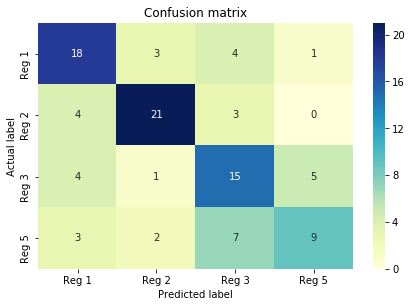

In [25]:
evaluate_performance(val_y, val_pred)

##### Examining variable importance
Since this is no longer a focus for the project, I'm not doing this for the other models. Just keeping this here in case we want to revisit it for the final project writeup.

In [9]:
# create a data frame with the coefficients for all the multiclass logit coefficients
coef_ovr = pd.DataFrame(clf.coef_, index=clf.classes_, columns=pred_names)

In [10]:
# sort predictors by the magnitude of their coefficients for regime 1
np.abs(coef_ovr.iloc[[0,]]).sort_values(by=1, axis=1, ascending=False)

,Effluent,Fishing_NonComm_Shore_Line,SST_STD,Depth,SST_CLIM_M,Fishing_NonComm_Boat_Total,Fishing_NonComm_Shore_Spear,Invasive_Algae,PAR_CLIM_M,Fishing_NonComm_Shore_Net,CHL_CLIM_M,Complexity,Habitat_Modification,WAV_ANOM_F,Sedimentation,Fishing_Comm_Total,CHL_ANOM_F,WAV_CLIM_M,New_Development,PAR_STD
1,2.639081,0.778184,0.646784,0.586206,0.521871,0.51951,0.388728,0.343639,0.294381,0.237793,0.221354,0.139958,0.135203,0.070958,0.061339,0.053058,0.032948,0.02542,0.018377,0.008124


In [11]:
# for regime 2
np.abs(coef_ovr.iloc[[1,]]).sort_values(by=2, axis=1, ascending=False)

,SST_STD,Effluent,Fishing_NonComm_Shore_Spear,WAV_ANOM_F,Complexity,CHL_CLIM_M,PAR_CLIM_M,Fishing_NonComm_Shore_Line,New_Development,WAV_CLIM_M,Fishing_NonComm_Boat_Total,Fishing_Comm_Total,SST_CLIM_M,Invasive_Algae,Habitat_Modification,PAR_STD,Depth,CHL_ANOM_F,Sedimentation,Fishing_NonComm_Shore_Net
2,0.711371,0.517009,0.418174,0.392961,0.378102,0.377502,0.333317,0.319895,0.299668,0.273372,0.272335,0.25337,0.239247,0.22945,0.218788,0.089631,0.08639,0.068502,0.025963,0.016966


In [12]:
# for regime 3
np.abs(coef_ovr.iloc[[2,]]).sort_values(by=3, axis=1, ascending=False)

,SST_STD,CHL_ANOM_F,Fishing_NonComm_Shore_Spear,Fishing_Comm_Total,WAV_CLIM_M,PAR_STD,Fishing_NonComm_Shore_Net,Fishing_NonComm_Shore_Line,CHL_CLIM_M,PAR_CLIM_M,Effluent,New_Development,SST_CLIM_M,Fishing_NonComm_Boat_Total,Habitat_Modification,Complexity,Invasive_Algae,WAV_ANOM_F,Sedimentation,Depth
3,0.953853,0.626184,0.588329,0.545212,0.486791,0.479164,0.3772,0.364994,0.361789,0.349736,0.335244,0.328058,0.291198,0.252243,0.236226,0.218227,0.17796,0.168712,0.016493,0.003376


In [13]:
# for regime 5
np.abs(coef_ovr.iloc[[3,]]).sort_values(by=5, axis=1, ascending=False)

,WAV_ANOM_F,PAR_STD,WAV_CLIM_M,Fishing_NonComm_Shore_Line,Fishing_Comm_Total,Fishing_NonComm_Shore_Spear,Depth,CHL_CLIM_M,Fishing_NonComm_Boat_Total,Habitat_Modification,Fishing_NonComm_Shore_Net,SST_STD,CHL_ANOM_F,PAR_CLIM_M,Complexity,Invasive_Algae,Effluent,SST_CLIM_M,New_Development,Sedimentation
5,0.918782,0.864808,0.604511,0.603624,0.578518,0.572434,0.540372,0.446496,0.394515,0.390409,0.370604,0.361754,0.356559,0.317852,0.293763,0.150484,0.127832,0.071772,0.069645,0.003165


### Multiclass logistic regression model (multinomial)

##### Fit the model & make predictions

In [14]:
clf_multi = LogisticRegression(solver='newton-cg', multi_class='multinomial')
clf_multi.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [15]:
# make predictions
val_pred_multi = clf_multi.predict(val_X)

##### Evaluate performance

Misclassified samples: 34
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.77      0.69        26
           2       0.80      0.71      0.75        28
           3       0.59      0.64      0.62        25
           5       0.62      0.48      0.54        21

   micro avg       0.66      0.66      0.66       100
   macro avg       0.66      0.65      0.65       100
weighted avg       0.67      0.66      0.66       100



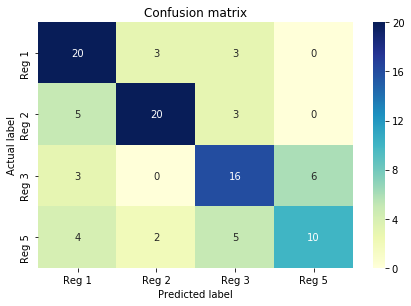

In [16]:
evaluate_performance(val_y, val_pred_multi)

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, zero_one_loss
C = np.logspace(-4, 4, 15)
hyperparameters = dict(C=C)
clf = GridSearchCV(LogisticRegression(solver='newton-cg',
                                      multi_class='multinomial', 
                                      penalty='l2',
                                      random_state=1), 
                   hyperparameters, cv=5, verbose=0, iid=False,
                   scoring=make_scorer(metrics.f1_score, average='micro', greater_is_better=True),
                   return_train_score=True)
best_model = clf.fit(train_X, train_y)

# Best Model is the model picked with the optimal C retrained on the
# entire training data.

print('Best C:', best_model.best_estimator_.get_params()['C'])

Best C: 0.2682695795279725


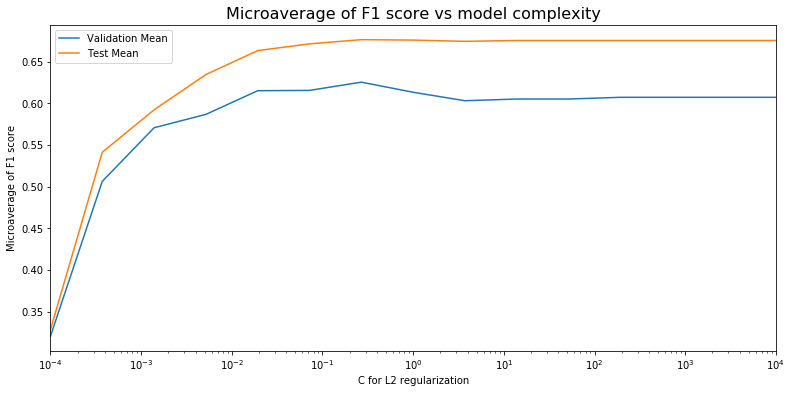

In [28]:
# from scikit-learn, "Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV" 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html
results = clf.cv_results_

plt.figure(figsize=(13, 6))
plt.title("Microaverage of F1 score vs model complexity",
          fontsize=16)

plt.xlabel("C for L2 regularization")
plt.ylabel("Microaverage of F1 score")

ax = plt.gca()
plt.xscale("log")
ax.set_xlim(C[0], C[-1])

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

sample_score_mean = results['mean_test_score']
# sample_score_std = results['std_test_score']

train_score_mean = results['mean_train_score']

# add error bars
plt.errorbar(x = X_axis, y = sample_score_mean, 
             label='Validation Mean', capsize=4, capthick=2)
plt.errorbar(x = X_axis, y = train_score_mean, 
             label='Test Mean', capsize=4, capthick=2)

plt.legend()

plt.grid(False)
plt.show()

## Confusion matrix for Cross Validated Regularization

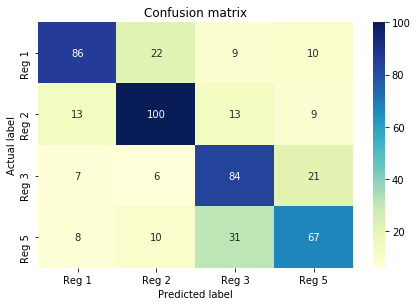

In [34]:
train_pred_multi = best_model.predict(train_X)
pretty_print_performance(train_y, train_pred_multi, False)

## Error Analysis